In [1]:
import json
import re
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# 원본 / 정규화 파일 경로
raw_path = "./data/wikipedia_documents.json"
clean_path = "./data/wikipedia_documents_normalized.json"

with open(raw_path, "r", encoding="utf-8") as f:
    raw_docs = json.load(f)

with open(clean_path, "r", encoding="utf-8") as f:
    clean_docs = json.load(f)

print(len(raw_docs), len(clean_docs))


60613 60613


In [15]:
from datasets import load_from_disk
from negative_sampling import NegativeSampler

ds = load_from_disk("./data/train_dataset")["train"]

# retriever mock (테스트용 더미 retriever)
class DummyRetriever:
    def retrieve(self, q, topk=20):
        return None, ["ctx1", "ctx2", "ctx3", "ctx4"]

sampler = NegativeSampler(retriever=DummyRetriever(), num_negative_samples=2)

aug = sampler.augment_train_dataset(ds)

print(aug[0])
print(len(aug))


{'title': '미국 상원', 'context': '미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.\\n\\n미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다.\\n\\n미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05', 'question': '대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?', 'id': 'mrc-1-000067', 'answers': {'answer_start': [2

In [68]:
from datasets import load_from_disk

neg = load_from_disk("./data/train_dataset/concat_final")
neg


DatasetDict({
    train: Dataset({
        features: ['id', 'document_id', 'question', 'context', 'answers'],
        num_rows: 3950
    })
    validation: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
        num_rows: 240
    })
})

In [69]:
import random

i = random.randint(0, len(neg)-1)
sample = neg[i]

print(" Question:\n", sample["question"])
print("\n Positive:\n", sample["positive"][:200], "...\n")

print("\n Easy:")
print(sample["negatives"]["easy"][:200], "...\n")

print("\n Mid:")
print(sample["negatives"]["mid"][:200], "...\n")

print("\n Hard samples:")
for h in sample["negatives"]["hard"]:
    print("- ", h[:200], "...\n")


KeyError: "Invalid key: 0. Please first select a split. For example: `my_dataset_dictionary['train'][0]`. Available splits: ['train', 'validation']"

In [74]:
from datasets import load_from_disk

orig = load_from_disk("./data/train_dataset_clean")["train"]
concat = load_from_disk("./data/train_dataset/negative11")


In [75]:
concat[0]

{'question': '대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?',
 'positive': '미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.\\n\\n미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다.\\n\\n미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05',
 'negatives': ['리히텐슈타인의 의회주의는 1862년 헌법과 함께 시작되었다고 할 수 있다. 이렇게 생긴 의회는

In [54]:
def check_alignment(orig_row, concat_row):
    ans_text = orig_row["answers"]["text"][0]
    ans_start_orig = orig_row["answers"]["answer_start"][0]

    # concat 구조 확인
    pos = concat_row["positive"]
    negs = concat_row["negatives"]
    easy = negs["easy"]
    mid = negs["mid"]
    hards = negs["hard"]

    # concat 순서 그대로
    concat_ctx = pos + " " + easy + " " + mid + " " + " ".join(hards)

    # 1) positive 내부 정답 검사
    if pos.find(ans_text) != ans_start_orig:
        return False, "❌ positive 내부 answer_start 불일치"

    # 2) concat context 내부 정답 검사
    concat_start = concat_ctx.find(ans_text)
    if concat_start != ans_start_orig:
        return False, "❌ concat 후 answer_start 위치가 달라짐"

    return True, "OK"

    


In [77]:
from datasets import load_from_disk
from transformers import AutoTokenizer
import numpy as np

# ==========================================
# 1. 두 dataset 로드
# ==========================================
ds_bad = load_from_disk("./data/train_dataset_with_negatives")["train"]
ds_good = load_from_disk("./data/concat_final")["train"]

print("BAD size:", len(ds_bad))
print("GOOD size:", len(ds_good))

# ==========================================
# 2. key 비교
# ==========================================
print("\n=== KEY 비교 ===")
print("BAD keys:", ds_bad.features.keys())
print("GOOD keys:", ds_good.features.keys())

# ==========================================
# 3. answers 구조 비교
# ==========================================
def check_answer_structure(ds, name):
    print(f"\n=== ANSWER STRUCTURE CHECK: {name} ===")
    for i in range(5):
        row = ds[i]["answers"]
        print(i, row, type(row["text"]), type(row["answer_start"]))

check_answer_structure(ds_bad, "BAD")
check_answer_structure(ds_good, "GOOD")

# ==========================================
# 4. context 길이 분포 비교
# ==========================================
bad_lengths = [len(ds_bad[i]["context"]) for i in range(len(ds_bad))]
good_lengths = [len(ds_good[i]["context"]) for i in range(len(ds_good))]

print("\n=== CONTEXT LENGTH ===")
print("BAD max:", max(bad_lengths), "mean:", np.mean(bad_lengths))
print("GOOD max:", max(good_lengths), "mean:", np.mean(good_lengths))

# ==========================================
# 5. answer substring 검증
# ==========================================
def answer_valid(ds, index):
    ctx = ds[index]["context"]
    ans = ds[index]["answers"]["text"][0]
    st = ds[index]["answers"]["answer_start"][0]
    if st < 0 or st + len(ans) > len(ctx):
        return False
    return ctx[st:st+len(ans)] == ans

print("\n=== ANSWER SUBSTRING CHECK ===")
cnt_bad = sum(not answer_valid(ds_bad, i) for i in range(len(ds_bad)))
cnt_good = sum(not answer_valid(ds_good, i) for i in range(len(ds_good)))

print("BAD invalid answers:", cnt_bad)
print("GOOD invalid answers:", cnt_good)

# ==========================================
# 6. tokenizer offset mismatch check
# ==========================================
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

def tokenizer_check(ds, index):
    ctx = ds[index]["context"]
    q = ds[index]["question"]
    enc = tokenizer(q, ctx, return_offsets_mapping=True, max_length=384, truncation=True)
    offsets = enc["offset_mapping"]

    # answer 정보
    ans = ds[index]["answers"]["text"][0]
    st = ds[index]["answers"]["answer_start"][0]
    end = st + len(ans)

    # tokenizer에서 answer가 포함된 토큰 찾기
    ok = False
    for off in offsets:
        if off[0] <= st <= off[1] or off[0] <= end <= off[1]:
            ok = True
            break
    return ok

print("\n=== TOKENIZER OFFSET CHECK (앞 100개) ===")
bad_token_err = sum(not tokenizer_check(ds_bad, i) for i in range(100))
good_token_err = sum(not tokenizer_check(ds_good, i) for i in range(100))

print("BAD tokenizer mismatch:", bad_token_err)
print("GOOD tokenizer mismatch:", good_token_err)


BAD size: 3952
GOOD size: 3950

=== KEY 비교 ===
BAD keys: dict_keys(['id', 'question', 'context', 'answers', 'title', 'document_id'])
GOOD keys: dict_keys(['id', 'document_id', 'question', 'context', 'answers'])

=== ANSWER STRUCTURE CHECK: BAD ===
0 {'answer_start': [235], 'text': ['하원']} <class 'list'> <class 'list'>
1 {'answer_start': [212], 'text': ['《경영의 실제》']} <class 'list'> <class 'list'>
2 {'answer_start': [510], 'text': ['백성']} <class 'list'> <class 'list'>
3 {'answer_start': [1718], 'text': ['중국']} <class 'list'> <class 'list'>
4 {'answer_start': [1919], 'text': ['4개']} <class 'list'> <class 'list'>

=== ANSWER STRUCTURE CHECK: GOOD ===
0 {'answer_start': [183], 'text': ['하원']} <class 'list'> <class 'list'>
1 {'answer_start': [212], 'text': ['《경영의 실제》']} <class 'list'> <class 'list'>
2 {'answer_start': [366], 'text': ['백성']} <class 'list'> <class 'list'>
3 {'answer_start': [625], 'text': ['중국']} <class 'list'> <class 'list'>
4 {'answer_start': [30], 'text': ['4개']} <class 'lis

In [61]:
from datasets import load_from_disk

ds = load_from_disk("./data/train_dataset/concat_final")
val = ds["validation"]

for i, row in enumerate(val):
    if not isinstance(row["context"], str):
        print("BAD CONTEXT", i, type(row["context"]), row["context"])
        break
    if not isinstance(row["question"], str):
        print("BAD QUESTION", i, type(row["question"]), row["question"])
        break
    if isinstance(row["answers"]["text"][0], list):
        print("BAD ANSWER", i, row["answers"])
        break

print("done check")


done check


In [62]:
from datasets import load_from_disk

clean = load_from_disk("./data/train_dataset_clean")
clean


DatasetDict({
    train: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
        num_rows: 3952
    })
    validation: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
        num_rows: 240
    })
})

In [63]:
clean["validation"].save_to_disk("./data/train_dataset/concat_final/validation")


Saving the dataset (1/1 shards): 100%|██████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 28696.99 examples/s]


In [89]:
ds1 = load_from_disk("./data/concat_final")["train"]
ds[1]

{'question': '현대적 인사조직관리의 시발점이 된 책은?',
 'positive': "'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 1950년대이다. 2차 세계대전을 마치고, 6.25전쟁의 시기로 유럽은 전후 재건에 집중하고, 유럽 제국주의의 식민지가 독립하여 아프리카, 아시아, 아메리카 대륙에서 신생국가가 형성되는 시기였고, 미국은 전쟁 이후 경제적 변화에 기업이 적응을 해야 하던 시기였다. 특히 1954년 피터 드러커의 저서 《경영의 실제》는 현대적 경영의 기준을 제시하여서, 기존 근대적 인사조직관리를 넘어선 현대적 인사조직관리의 전환점이 된다. 드러커는 경영자의 역할을 강조하며 경영이 현시대 최고의 예술이자 과학이라고 주장하였고 , 이 주장은 21세기 인사조직관리의 역할을 자리매김했다.\\n\\n현대적 인사조직관리와 근대 인사조직관리의 가장 큰 차이는 통합이다. 19세기의 영향을 받던 근대적 경영학(고전적 경영)의 흐름은 기능을 강조하였지만, 1950년대 이후의 현대 경영학은 통합을 강조하였다. 기능이 분화된 '기계적인 기업조직' 이해에서 다양한 기능을 인사조직관리의 목적, 경영의 목적을 위해서 다양한 분야를 통합하여 '유기적 기업 조직' 이해로 전환되었다. 이 통합적 접근방식은 과정, 시스템, 상황을 중심으로 하는 인사조직관리 방식을 형성했다.",
 'negatives': ["'근대적 경영관리' 또는 '고전적 경영관리'에서 현대적 경영관리로 전환되는 시기는 1950년대이다. 2차 세계대전을 마치고, 한국전쟁의 시기로 유럽은 전후 재건에 집중하고, 유럽 제국주의의 식민지가 독립하여 아프리카, 아시아, 아메리카 대륙에서 신생국가가 형성되는 시기였고, 미국은 전쟁 이후 경제적 변화에 기업이 적응을 해야 하던 시기였다. 특히 1954년 피터 드러커의 저서 《경영의 실제》는 기존 근대적 경영관리를 넘어선 현대적 경영관리의 전환점이 된다 . 드러커는 경영자의 역할을 강조하며 경영이 현시대 최고의 예술이자 과학이라고 주장하였

In [88]:
from datasets import load_from_disk

ds = load_from_disk("./data/train_dataset/negative")
ds[1]
ds1[1]

{'id': 'mrc-0-004397',
 'document_id': 51638,
 'question': '현대적 인사조직관리의 시발점이 된 책은?',
 'context': '\'근대적 경영학\' 또는 \'고전적 경영학\'에서 현대적 경영학으로 전환되는 시기는 1950년대이다. 2차 세계대전을 마치고, 6.25전쟁의 시기로 유럽은 전후 재건에 집중하고, 유럽 제국주의의 식민지가 독립하여 아프리카, 아시아, 아메리카 대륙에서 신생국가가 형성되는 시기였고, 미국은 전쟁 이후 경제적 변화에 기업이 적응을 해야 하던 시기였다. 특히 1954년 피터 드러커의 저서 《경영의 실제》는 현대적 경영의 기준을 제시하여서, 기존 근대적 인사조직관리를 넘어선 현대적 인사조직관리의 전환점이 된다. 드러커는 경영자의 역할을 강조하며 경영이 현시대 최고의 예술이자 과학이라고 주장하였고 , 이 주장은 21세기 인사조직관리의 역할을 자리매김했다.\\n\\n현대적 인사조직관리와 근대 인사조직관리의 가장 큰 차이는 통합이다. 19세기의 영향을 받던 근대적 경영학(고전적 경영)의 흐름은 기능을 강조하였지만, 1950년대 이후의 현대 경영학은 통합을 강조하였다. 기능이 분화된 \'기계적인 기업조직\' 이해에서 다양한 기능을 인사조직관리의 목적, 경영의 목적을 위해서 다양한 분야를 통합하여 \'유기적 기업 조직\' 이해로 전환되었다. 이 통합적 접근방식은 과정, 시스템, 상황을 중심으로 하는 인사조직관리 방식을 형성했다. [SEP] 《자연 선택의 유전학적 이론》은 영국의 유전학자 로날드 피셔가 1930년 출간한 책으로 멘델의 유전법칙과 찰스 다윈의 자연 선택 이론을 함께 묶어 설명하고 있다. 피셔는 이 책에서 "멘델 유전학은 다윈의 진화론을 입증한다"고 주장하였고 돌연변이를 진화의 원동력으로 지목하여 "대다수의 돌연변이는 해롭고 얼마간의 돌연변이는 큰 차이가 없지만 드물게 오히려 더 유용한 돌연변이가 나타난다"는 이유로 정향진화설 초판은 1930년 옥스퍼드 대학교 출판부 클라렌던 출판소에서 인쇄되

In [65]:
from datasets import load_from_disk
from transformers import AutoTokenizer

ds = load_from_disk("./data/train_dataset/concat_final")
val = ds["validation"]
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

bad = []

for i,row in enumerate(val):
    try:
        out = tokenizer(
            row["question"],
            row["context"],
            truncation=True,
            max_length=512,
            padding="max_length",
        )
        # 길이가 맞는지 검사
        if len(out["input_ids"]) != 512:
            bad.append(i)
            print("BAD LEN:", i, len(out["input_ids"]))
            break
    except Exception as e:
        print("ERROR at", i, e)
        bad.append(i)
        break

print("done", bad[:10])


done []


In [67]:
from datasets import load_from_disk

ds = load_from_disk("./data/train_dataset/concat_final")
val = ds["validation"]

bad_rows = []

for i, row in enumerate(val):
    ok = True
    
    # context는 문자열이어야 함
    if not isinstance(row["context"], str):
        print("BAD CONTEXT:", i, row["context"])
        ok = False
    
    # question도 문자열이어야 함
    if not isinstance(row["question"], str):
        print("BAD QUESTION:", i, row["question"])
        ok = False
    
    # answers는 dict, 내부 text는 list여야 함
    a = row["answers"]
    if not isinstance(a, dict):
        print("BAD ANSWER (not dict):", i, a)
        ok = False
    else:
        if "text" not in a or "answer_start" not in a:
            print("BAD ANSWER (missing keys):", i, a)
            ok = False
        else:
            if not isinstance(a["text"], list):
                print("BAD ANSWER text type:", i, a)
                ok = False
            if not isinstance(a["answer_start"], list):
                print("BAD ANSWER start type:", i, a)
                ok = False
    
    if not ok:
        bad_rows.append(i)

print("BAD ROWS:", bad_rows)


BAD ROWS: []


In [66]:
from datasets import load_from_disk
ds = load_from_disk("./data/train_dataset/concat_final")

print(ds["validation"].column_names)

['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__']


In [56]:
def check_alignment(orig_row, concat_row):
    # 원본 정답 정보
    ans_text = orig_row["answers"]["text"][0]
    ans_start_orig = orig_row["answers"]["answer_start"][0]

    # concat된 최종 context
    concat_ctx = concat_row["context"]

    # concat에서 정답 위치 찾기
    new_start = concat_ctx.find(ans_text)

    if new_start == -1:
        return False, "정답 문자열이 concat context에서 사라짐"

    if new_start != ans_start_orig:
        return False, f"answer_start mismatch: orig={ans_start_orig}, new={new_start}"

    return True, "OK"


In [57]:
bad = []

for i in range(len(concat)):
    ok, msg = check_alignment(orig[i], concat[i])
    if not ok:
        bad.append((i, msg))

print("문제 있는 샘플 개수:", len(bad))
bad[:10]


문제 있는 샘플 개수: 3208


[(0, 'answer_start mismatch: orig=235, new=183'),
 (2, 'answer_start mismatch: orig=510, new=366'),
 (14, 'answer_start mismatch: orig=497, new=428'),
 (16, 'answer_start mismatch: orig=414, new=178'),
 (19, 'answer_start mismatch: orig=585, new=300'),
 (28, 'answer_start mismatch: orig=256, new=5'),
 (29, 'answer_start mismatch: orig=1135, new=826'),
 (36, 'answer_start mismatch: orig=228, new=6'),
 (48, 'answer_start mismatch: orig=456, new=276'),
 (60, 'answer_start mismatch: orig=170, new=146')]

In [2]:
raw_lengths = [len(doc["text"]) for doc in raw_docs.values()]
clean_lengths = [len(doc["text"]) for doc in clean_docs.values()]

print("📌 평균 길이 변화:", np.mean(raw_lengths), "→", np.mean(clean_lengths))
print("📌 중앙값:", np.median(raw_lengths), "→", np.median(clean_lengths))
print("📌 최대 길이:", max(raw_lengths), "→", max(clean_lengths))


📌 평균 길이 변화: 755.5650438024846 → 747.6302938313563
📌 중앙값: 577.0 → 572.0
📌 최대 길이: 46099 → 42646


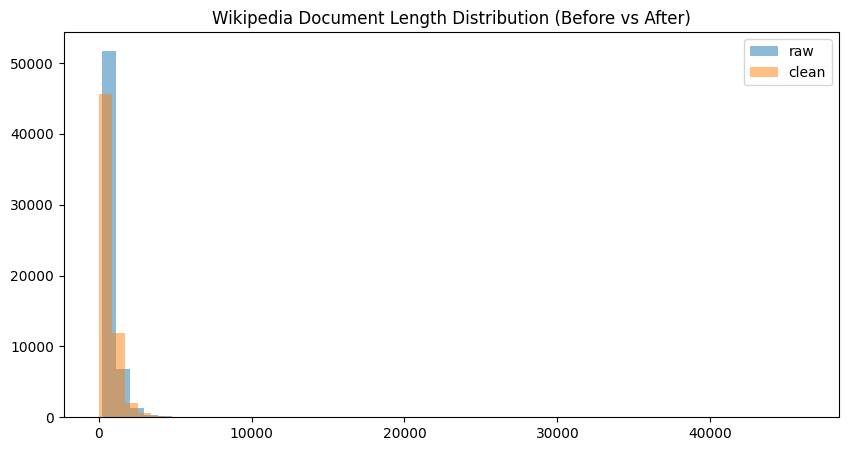

In [3]:
plt.figure(figsize=(10,5))
plt.hist(raw_lengths, bins=50, alpha=0.5, label="raw")
plt.hist(clean_lengths, bins=50, alpha=0.5, label="clean")
plt.legend()
plt.title("Wikipedia Document Length Distribution (Before vs After)")
plt.show()


In [4]:
def count_html(text):
    return len(re.findall(r"<[^>]+>", text))

raw_html = sum(count_html(doc["text"]) for doc in raw_docs.values())
clean_html = sum(count_html(doc["text"]) for doc in clean_docs.values())

print("HTML 태그 개수:", raw_html, "→", clean_html)


HTML 태그 개수: 7570 → 0


Reference 개수: 0 → 0


In [9]:
import re

# URL 정규식 패턴
url_pattern = r"(https?://\S+|www\.\S+)"
def count_urls(text):
    return len(re.findall(url_pattern, text))

raw_urls = sum(count_urls(doc["text"]) for doc in raw_docs.values())
clean_urls = sum(count_urls(doc["text"]) for doc in clean_docs.values())

print("📌 URL 개수:", raw_urls, "→", clean_urls)



📌 URL 개수: 823 → 0


In [7]:
for i, key in enumerate(list(raw_docs.keys())[:5]):
    print("="*80)
    print("📌 BEFORE\n", raw_docs[key]["text"][:500])
    print("\n📌 AFTER\n", clean_docs[key]["text"][:500])
    print()


📌 BEFORE
 이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개요 형태로 나열하고 있다.

이 목록은 명료화를 위해 두 부분으로 나뉘어 있다.

# 첫 번째 부분은 바티칸 시국과 팔레스타인을 포함하여 유엔 등 국제 기구에 가입되어 국제적인 승인을 널리 받았다고 여기는 195개 나라를 나열하고 있다.
# 두 번째 부분은 일부 지역의 주권을 사실상 (데 팍토) 행사하고 있지만, 아직 국제적인 승인을 널리 받지 않았다고 여기는 11개 나라를 나열하고 있다.

두 목록은 모두 가나다 순이다.

일부 국가의 경우 국가로서의 자격에 논쟁의 여부가 있으며, 이 때문에 이러한 목록을 엮는 것은 매우 어렵고 논란이 생길 수 있는 과정이다. 이 목록을 구성하고 있는 국가를 선정하는 기준에 대한 정보는 "포함 기준" 단락을 통해 설명하였다. 나라에 대한 일반적인 정보는 "국가" 문서에서 설명하고 있다.

📌 AFTER
 이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개요 형태로 나열하고 있다. 이 목록은 명료화를 위해 두 부분으로 나뉘어 있다. # 첫 번째 부분은 바티칸 시국과 팔레스타인을 포함하여 유엔 등 국제 기구에 가입되어 국제적인 승인을 널리 받았다고 여기는 195개 나라를 나열하고 있다. # 두 번째 부분은 일부 지역의 주권을 사실상 (데 팍토) 행사하고 있지만, 아직 국제적인 승인을 널리 받지 않았다고 여기는 11개 나라를 나열하고 있다. 두 목록은 모두 가나다 순이다. 일부 국가의 경우 국가로서의 자격에 논쟁의 여부가 있으며, 이 때문에 이러한 목록을 엮는 것은 매우 어렵고 논란이 생길 수 있는 과정이다. 이 목록을 구성하고 있는 국가를 선정하는 기준에 대한 정보는 "포함 기준" 단락을 통해 설명하였다. 나라에 대한 일반적인 정보는 "국가" 문서에서 설명하고 있다.

📌 BEFORE
 이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정에 따르면, 국가는 다음의 조건

In [10]:
samples = []

for k, v in raw_docs.items():
    if count_urls(v["text"]) > 0:
        samples.append(k)
    if len(samples) == 5:
        break

for key in samples:
    print("="*80)
    print("📌 BEFORE TEXT (with URL)")
    print(raw_docs[key]["text"][:500])
    
    print("\n📌 AFTER TEXT")
    print(clean_docs[key]["text"][:500])
    print()


📌 BEFORE TEXT (with URL)
각각의 모든 웹사이트 또는 홈페이지는 특수한 단하나의 예약된 'index.html'이라는 페이지를 갖고있다.
이는 최초 인트로 웹페이지이며  웹브라우저는 디폴트로 브라우저가 방문한 사이트(디렉토리)의 'index.html'의 이름을 갖는  HTML파일을 우선적으로 읽어들이도록 되어있다.
이러한 index.html 파일은 일반적으로 <frameset> 태그와 하위의 <frame>태그로 영역 구획 및 여기에 콘텐츠를 넘겨주는 기능을 하는 간단한 구조의 그릇 역할처럼 설정되곤 한다.(MDN -frameset example)<frameset cols="50%,50%">
  <frame src="http://developer.mozilla.org/en-US/docs/Web/HTML/Element/frameset" />
  <frame src="http://developer.mozilla.org/en-US/docs/Web/HTML/Element/frame" />
</frameset> (http

📌 AFTER TEXT
각각의 모든 웹사이트 또는 홈페이지는 특수한 단하나의 예약된 'index.html'이라는 페이지를 갖고있다. 이는 최초 인트로 웹페이지이며 웹브라우저는 디폴트로 브라우저가 방문한 사이트(디렉토리)의 'index.html'의 이름을 갖는 HTML파일을 우선적으로 읽어들이도록 되어있다. 이러한 index.html 파일은 일반적으로 태그와 하위의 태그로 영역 구획 및 여기에 콘텐츠를 넘겨주는 기능을 하는 간단한 구조의 그릇 역할처럼 설정되곤 한다.(MDN -frameset example) ( (index.html의 가벼운 구조) //menu side //contents

📌 BEFORE TEXT (with URL)
베토벤이 하일리겐슈타트에서 빈으로 돌아온 것은 음악적 양식의 변화로 표시되었으며, 현재는 대규모로 작곡된 많은 창작품을 특징으로 하는 그의 중기 또는 "영웅적" 시기의 시작으로 지정되는 경우가 많다.p=13